# Deep Neural Network

## Setup

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Vanishing/Exploding Gradients Problem

In [3]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [4]:
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
distribution='uniform')
keras.layers.Dense(10, activation="sigmoid", kernel_initializer=he_avg_init)

## Batch Normalization

In [5]:
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28,28]),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(10, activation="softmax")
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [7]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [8]:
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28,28]),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal",use_bias=False),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",use_bias=False),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(10, activation="softmax")
])

## Gradient Clipping

In [9]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [10]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## Learning Rate Schedluling

### Adam Optimization

In [11]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

### Power scheduling

In [12]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

### Exponential Scheduling

In [13]:
def exponential_decay_fn(epoch):
  return 0.01 * 0.1**(epoch / 20)

In [14]:
def exponential_decay(lr0, s):
  def exponential_decay_fn(epoch):
    return lr0 * 0.1 *(epoch /s )
  return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

### Setting up Learning Rate Scheduler for Exponential Decay

In [15]:
# X_train, y_train = [], []
# lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
# history = model.fit(X_train, y_train, callbacks=[lr_scheduler])

In [16]:
def exponential_decay_fn(epoch, lr):
  return lr * 0.1**(1/20)

### Piecewise Constant Scheduling

In [17]:
def piecewise_constant_fn(epoch):
  if epoch < 5:
    return 0.01
  elif epoch < 15:
    return 0.005
  else:
    return 0.001

### Learning Rate Scheduler Callback for Piecewise Constant Scheduling

In [18]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

In [19]:
X_train = []
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate = learning_rate)

## Avoid Overfitting Through Regularization

### L1 and L2 Regularizatoin

In [20]:
layer = keras.layers.Dense( 100, activation="elu", kernel_initializer="he_normal",
kernel_regularizer=keras.regularizers.l2(0.01))

In [21]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                          activation="elu",
                          kernel_initializer="he_normal",
                          kernel_regularizer=keras.regularizers.l2(0.01)
                          )

model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28,28]),
  RegularizedDense(300),
  RegularizedDense(100),
  RegularizedDense(10, activation="softmax", kernel_initializer="glorot_uniform")
])

### Dropout

In [22]:
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28,28]),
  keras.layers.Dropout(rate=0.2),
  keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
  keras.layers.Dropout(rate=0.2),
  keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
  keras.layers.Dropout(rate=0.2),
  keras.layers.Dense(10, activation="elu", kernel_initializer="he_normal"),
])

### MC Dropout

In [23]:
# y_probas = np.stack([model(X_test_scaled, training=True)]
#                     for sample in range(100))
# y_proba = y_probas.mean(axis=0)


### Max-Norm Regularization

In [24]:
keras.layers.Dense(100, activation="elu",
                  kernel_initializer="he_normal",
                  kernel_constraint = keras.constraints.max_norm(1.) )

## Exercise 8.

In [25]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
#Creating Sequential Model
model = keras.models.Sequential()
#Input Layer which is composed for 32x32 sized images w/ colors RBB(R, G, B) hence the 3
model.add(keras.layers.Flatten(input_shape=[32,32,3]))

for i in range(20):
  model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))

#Output Layer for differenciating the different Data
model.add(keras.layers.Dense(10, activation="softmax"))


In [26]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [27]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

In [28]:
#Adding Callbacks to be able to repeat the process and to compare the two
#Stop running epochs if no significant progress made in 10 epochs
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
#Save teh best model
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
#Tensorboard Callback
run_index=1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs","run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

#All callbacks into list
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [ ]:
%tensorboard --logdir=./my_cifar10_logs --port=6006

Reusing TensorBoard on port 6006 (pid 1664), started 1 day, 19:10:21 ago. (Use '!kill 1664' to kill it.)

In [31]:
model.fit(X_train, y_train, 
          epochs=100, 
          validation_data=(X_valid, y_valid), 
          callbacks=callbacks)


Epoch 1/100
1407/1407 [==============================] - 12s 6ms/step - loss: 6.7065 - accuracy: 0.1640 - val_loss: 2.3867 - val_accuracy: 0.1820
Epoch 2/100
 280/1407 [====>.........................] - ETA: 6s - loss: 2.1371 - accuracy: 0.2281

KeyboardInterrupt: 

In [84]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.5165 - accuracy: 0.4580


[1.516524076461792, 0.4580000042915344]

In [32]:
#Adding Batch Normalization to the end of each layer besides for the output layer each Layer

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))
#Adding Batch Normalization to the very first layer before the first hidden layer
for i in range(20):
  model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation("elu"))
#Output layer with softmax activation
model.add(keras.layers.Dense(10, activation="softmax"))

#Optimizers for the model and Comilation
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

#Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks= [early_stopping_cb,model_checkpoint_cb, tensorboard_cb]
#Fitting the Model

model.fit(X_train, y_train,
          epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/100


KeyboardInterrupt: 

In [33]:
#SELU instead of Batch Normilzation (also use LeCun initialization)

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))
#Adding Batch Normalization to the very first layer before the first hidden layer
for i in range(20):
  model.add(keras.layers.Dense(100,
                              kernel_initializer="lecun_normal",
                              activation="selu"))
#Output layer with softmax activation
model.add(keras.layers.Dense(10, activation="softmax"))

#Optimizers for the model and Comilation
optimizer = keras.optimizers.Nadam(learning_rate=7e-4) #Different learning rate
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

#Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks= [early_stopping_cb,model_checkpoint_cb, tensorboard_cb]

#Shaping the Data
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

#Fitting the Model
model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 12s 7ms/step - loss: 1.9028 - accuracy: 0.3216 - val_loss: 1.8474 - val_accuracy: 0.3482
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.6984 - accuracy: 0.3999 - val_loss: 1.7947 - val_accuracy: 0.3474
Epoch 3/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.6019 - accuracy: 0.4346 - val_loss: 1.7130 - val_accuracy: 0.3970
Epoch 4/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.5365 - accuracy: 0.4613 - val_loss: 1.6063 - val_accuracy: 0.4456
Epoch 5/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.4802 - accuracy: 0.4825 - val_loss: 1.5612 - val_accuracy: 0.4598
Epoch 6/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.4378 - accuracy: 0.4985 - val_loss: 1.5162 - val_accuracy: 0.4764
Epoch 7/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3913 - accuracy: 0.5130 - val_loss: 1.5164 - val_

[29.428749084472656, 0.20080000162124634]

In [35]:
# AlphaDropout to regularize the model w/ SELU (also use LeCun initialization)

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))
#Adding Batch Normalization to the very first layer before the first hidden layer
for i in range(20):
  model.add(keras.layers.Dense(100,
                              kernel_initializer="lecun_normal",
                              activation="selu"))
#AlphaDroput Layer 
model.add(keras.layers.AlphaDropout(rate=0.1))
#Output layer with softmax activation
model.add(keras.layers.Dense(10, activation="softmax"))

#Optimizers for the model and Comilation
optimizer = keras.optimizers.Nadam(learning_rate=7e-4) #Different learning rate
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

#Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks= [early_stopping_cb,model_checkpoint_cb, tensorboard_cb]

#Shaping the Data
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

#Fitting the Model
model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 12s 6ms/step - loss: 1.8961 - accuracy: 0.3244 - val_loss: 1.8207 - val_accuracy: 0.3342
Epoch 2/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.6859 - accuracy: 0.4047 - val_loss: 1.7135 - val_accuracy: 0.3730
Epoch 3/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.6093 - accuracy: 0.4350 - val_loss: 1.7282 - val_accuracy: 0.4070
Epoch 4/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.5542 - accuracy: 0.4551 - val_loss: 1.6176 - val_accuracy: 0.4308
Epoch 5/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4983 - accuracy: 0.4748 - val_loss: 1.7022 - val_accuracy: 0.4306
Epoch 6/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4546 - accuracy: 0.4932 - val_loss: 1.5768 - val_accuracy: 0.4680
Epoch 7/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4138 - accuracy: 0.5047 - val_loss: 1.5887 - val_a

[40.018829345703125, 0.25200000405311584]

In [36]:
#Alpha Dropout regularization instead of Batch Normilzation (also use LeCun initialization)

class MCAlphaDropout(keras.layers.AlphaDropout):
  def call(self, inputs):
    return super().call(inputs, training=True)



In [37]:
mc_model = keras.models.Sequential([
  MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [39]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
  Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
  return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
  Y_probas = mc_dropout_predict_probas(mc_model,  X, n_samples)
  return np.argmax(Y_probas, axis=1)

In [40]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:,0])
accuracy

0.4888

In [81]:
# 1cycle shecudling to observe if there are improvements in the model the model w/ SELU (also use LeCun initialization)

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


In [79]:
#Methods to use for 1cycle scheduling
import math
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
  def __init__(self, factor):
    self.factor = factor
    self.rates = []
    self.losses = []
  def on_batch_end(self, batch, logs):
    self.rates.append(K.get_value(self.model.optimizer.learning_rate))
    self.losses.append(logs["loss"])
    K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
  init_weights = model.get_weights()
  iterations = math.ceil(len(X) / batch_size) * epochs
  factor = np.exp(np.log(max_rate / min_rate) / iterations)
  init_lr = K.get_value(model.optimizer.learning_rate)
  K.set_value(model.optimizer.learning_rate, min_rate)
  exp_lr = ExponentialLearningRate(factor)
  history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                      callbacks=[exp_lr])
  K.set_value(model.optimizer.learning_rate, init_lr)
  model.set_weights(init_weights)
  return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
  plt.plot(rates, losses)
  plt.gca().set_xscale('log')
  plt.hlines(min(losses), min(rates), max(rates))
  plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) /2])
  plt.xlabel("Learning Rate")
  plt.ylabel("Loss")



352/352 [==============================] - 2s 6ms/step - loss: nan - accuracy: 0.1368


(9.999999747378752e-06,
 9.615227699279785,
 2.6148769855499268,
 3.973550115312849)

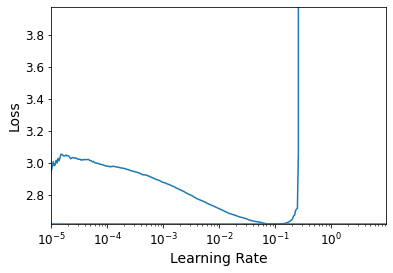

In [86]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses) ,(losses[0] + min(losses)) / 1.4])

In [106]:
#Rerun 1cycle to improve the model
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))
#Adding Batch Normalization to the very first layer before the first hidden layer
for i in range(20):
  model.add(keras.layers.Dense(100,
                              kernel_initializer="lecun_normal",
                              activation="selu"))
#AlphaDroput Layer 
model.add(keras.layers.AlphaDropout(rate=0.1))
#Output layer with softmax activation
model.add(keras.layers.Dense(10, activation="softmax"))

#Optimizers for the model and Comilation
optimizer = keras.optimizers.SGD(learning_rate=1e-3) #Different learning rate
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


In [107]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [105]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 3s 7ms/step - loss: 2.0517 - accuracy: 0.2890 - val_loss: 1.7945 - val_accuracy: 0.3772
Epoch 2/15
352/352 [==============================] - 2s 6ms/step - loss: 1.7612 - accuracy: 0.3758 - val_loss: 1.6345 - val_accuracy: 0.4232
Epoch 3/15
352/352 [==============================] - 2s 6ms/step - loss: 1.6161 - accuracy: 0.4255 - val_loss: 1.6279 - val_accuracy: 0.4294
Epoch 4/15
352/352 [==============================] - 2s 7ms/step - loss: 1.5418 - accuracy: 0.4572 - val_loss: 1.6117 - val_accuracy: 0.4348
Epoch 5/15
352/352 [==============================] - 2s 6ms/step - loss: 1.4917 - accuracy: 0.4715 - val_loss: 1.5634 - val_accuracy: 0.4650
Epoch 6/15
352/352 [==============================] - 2s 6ms/step - loss: 1.4498 - accuracy: 0.4854 - val_loss: 1.5302 - val_accuracy: 0.4766
Epoch 7/15
352/352 [==============================] - 2s 6ms/step - loss: 1.4133 - accuracy: 0.4984 - val_loss: 1.6117 - val_accuracy: 0.4444
Epoch 